This notebook is based on Slawek Biel's notebook (https://www.kaggle.com/slawekbiel/positive-score-with-detectron-3-3-inference)

Please UPVOTE !!

## Inference and submission
Now, we have trained model ([train with livecell](https://www.kaggle.com/markunys/sartorius-transfer-learning-train-with-livecell), [train](https://www.kaggle.com/markunys/sartorius-transfer-learning-train)). Let's inference with the model !!

In [1]:
!pip install ../input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/antlr4-python3-runtime-4.8/antlr4-python3-runtime-4.8 --no-index --find-links ../input/detectron-05/whls 
!pip install ../input/detectron-05/whls/detectron2-0.5/detectron2 --no-index --find-links ../input/detectron-05/whls 

Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/pycocotools-2.0.2/dist/pycocotools-2.0.2.tar
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272237 sha256=eaab77489791d65b5bde3aba9b2521eb96879a6448661bb9c7409245b57d979c
  Stored in directory: /root/.cache/pip/wheels/d2/09/29/2054c6cc4599cf39f1c52ce3c20bfb50be696caa5d5ba460c9
Successfully built pycocotools
Looking in links: ../input/detectron-05/whls
Processing /kaggle/input/detectron-05/whls/fvcore-0.1.5.post20211019/fvcore-0.1.5.post20211019
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
Processing /kaggle/in

In [2]:
import detectron2
import torch
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from PIL import Image
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fastcore.all import *

In [3]:
dataDir=Path('../input/sartorius-cell-instance-segmentation')

In [4]:
# From https://www.kaggle.com/stainsby/fast-tested-rle
def rle_decode(mask_rle, shape=(520, 704)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def get_masks(fn, predictor):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    pred_class = torch.mode(pred['instances'].pred_classes)[0]
    take = pred['instances'].scores >= THRESHOLDS[pred_class]
    pred_masks = pred['instances'].pred_masks[take]
    pred_masks = pred_masks.cpu().numpy()
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    print(pred)
    for mask in pred_masks:
        mask = mask * (1-used)
        if mask.sum() >= MIN_PIXELS[pred_class]: # skip predictions with small area
            used += mask
            res.append(rle_encode(mask))
    return res


In [5]:
ids, masks=[],[]
test_names = (dataDir/'test').ls()

### Initiate a Predictor from our trained model

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.INPUT.MASK_FORMAT='bitmask'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3 
cfg.MODEL.WEIGHTS = os.path.join('../input/sartorius-transfer-learning-model', "model_0009679.pth")  
cfg.TEST.DETECTIONS_PER_IMAGE = 1000
predictor = DefaultPredictor(cfg)
THRESHOLDS = [.15, .35, .55]
MIN_PIXELS = [75, 150, 75]

### Look at the outputs on a sample test file to sanity check
I'm encoding here in the competition format and decoding back to bit mask just to make sure everything is fine

In [7]:
encoded_masks = get_masks(test_names[0], predictor)

/opt/conda/lib/python3.7/site-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


{'instances': Instances(num_instances=220, image_height=520, image_width=704, fields=[pred_boxes: Boxes(tensor([[2.8736e+02, 5.0207e+02, 3.0363e+02, 5.2000e+02],
        [4.4344e+02, 6.3548e-02, 4.5851e+02, 1.7635e+01],
        [7.4064e+01, 2.5245e+02, 8.8022e+01, 2.7703e+02],
        [6.0790e+02, 1.9653e+02, 6.3258e+02, 2.2142e+02],
        [6.7088e+02, 1.3470e+02, 6.8516e+02, 1.6104e+02],
        [3.3939e+02, 4.5406e+02, 3.5019e+02, 4.8172e+02],
        [3.7489e+02, 2.0969e+02, 3.9920e+02, 2.3648e+02],
        [3.9049e+02, 3.1826e+02, 4.2126e+02, 3.2998e+02],
        [3.0324e+02, 3.6053e+02, 3.3618e+02, 3.7667e+02],
        [2.9027e+02, 1.5420e+02, 3.1133e+02, 1.7161e+02],
        [1.7811e+02, 2.5924e+02, 1.9837e+02, 2.9006e+02],
        [5.6961e+02, 3.6252e+01, 5.9336e+02, 5.3887e+01],
        [2.5561e+02, 8.3767e+01, 2.7761e+02, 1.0486e+02],
        [9.6081e+01, 2.5067e+02, 1.0998e+02, 2.7726e+02],
        [1.7199e+02, 4.0028e+02, 1.9129e+02, 4.1280e+02],
        [2.7531e+02, 2.917

{'instances': Instances(num_instances=220, image_height=520, image_width=704, fields=[pred_boxes: Boxes(tensor([[2.8736e+02, 5.0207e+02, 3.0363e+02, 5.2000e+02],
        [4.4344e+02, 6.3548e-02, 4.5851e+02, 1.7635e+01],
        [7.4064e+01, 2.5245e+02, 8.8022e+01, 2.7703e+02],
        [6.0790e+02, 1.9653e+02, 6.3258e+02, 2.2142e+02],
        [6.7088e+02, 1.3470e+02, 6.8516e+02, 1.6104e+02],
        [3.3939e+02, 4.5406e+02, 3.5019e+02, 4.8172e+02],
        [3.7489e+02, 2.0969e+02, 3.9920e+02, 2.3648e+02],
        [3.9049e+02, 3.1826e+02, 4.2126e+02, 3.2998e+02],
        [3.0324e+02, 3.6053e+02, 3.3618e+02, 3.7667e+02],
        [2.9027e+02, 1.5420e+02, 3.1133e+02, 1.7161e+02],
        [1.7811e+02, 2.5924e+02, 1.9837e+02, 2.9006e+02],
        [5.6961e+02, 3.6252e+01, 5.9336e+02, 5.3887e+01],
        [2.5561e+02, 8.3767e+01, 2.7761e+02, 1.0486e+02],
        [9.6081e+01, 2.5067e+02, 1.0998e+02, 2.7726e+02],
        [1.7199e+02, 4.0028e+02, 1.9129e+02, 4.1280e+02],
        [2.7531e+02, 2.917

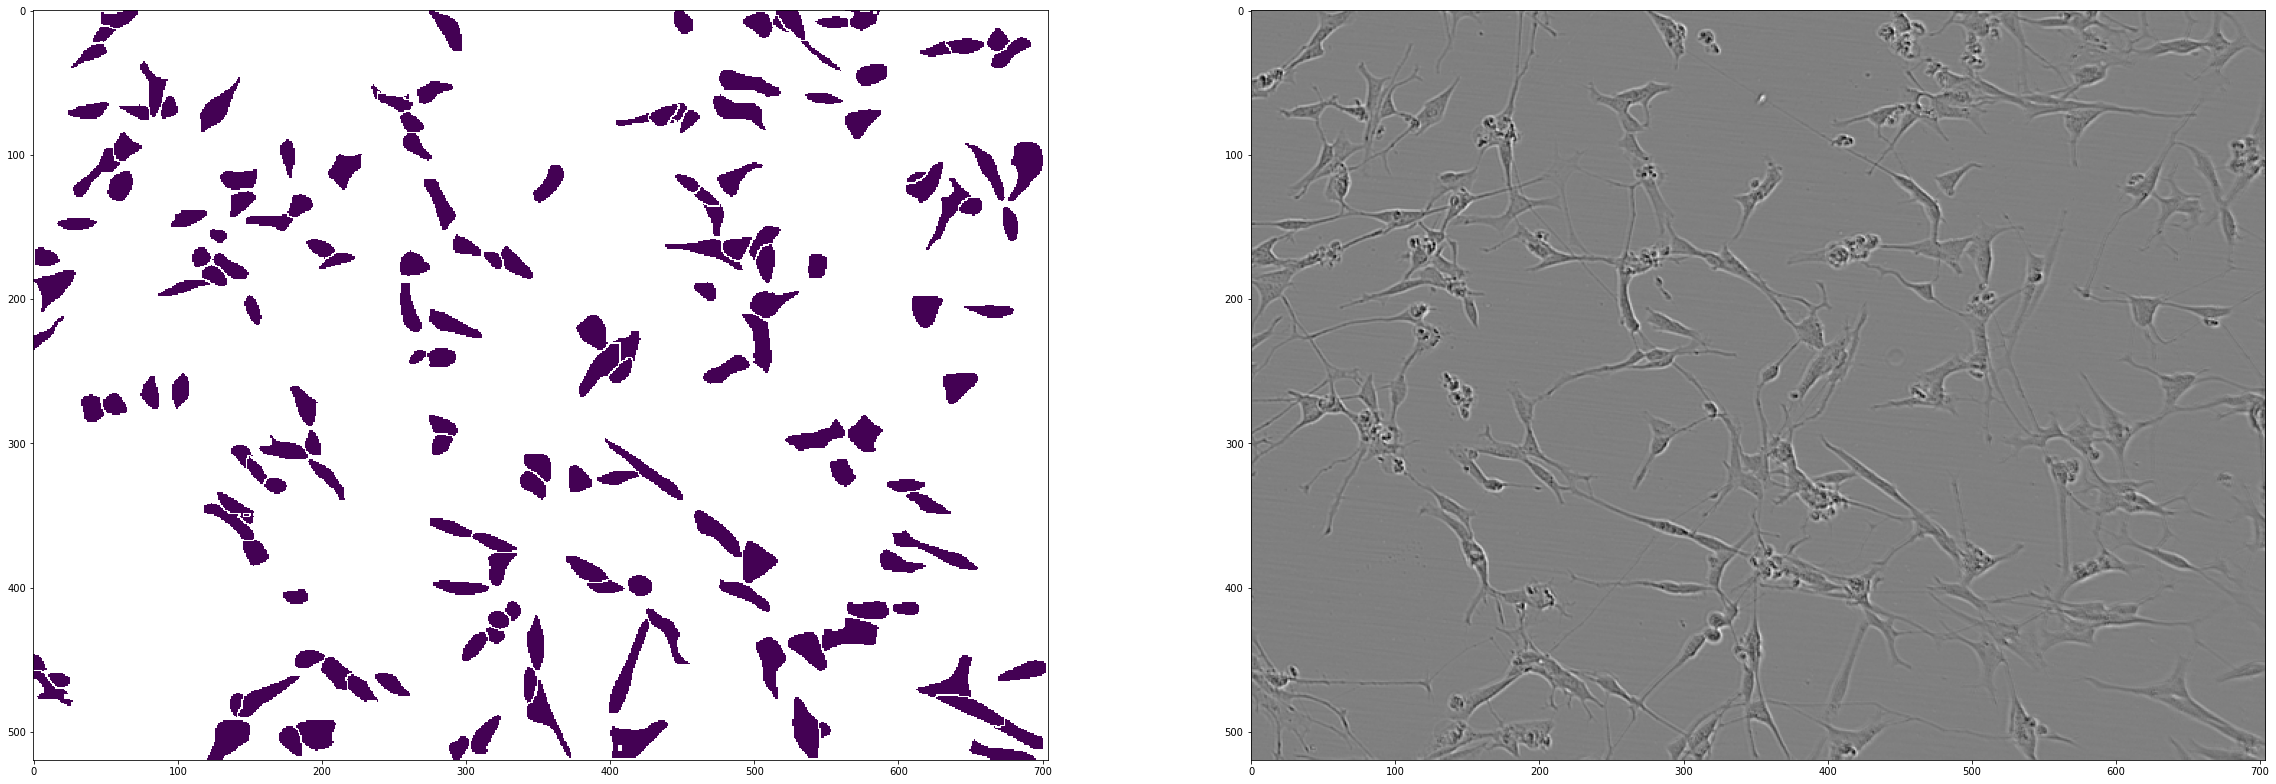

In [8]:
encoded_masks = get_masks(test_names[0], predictor)

_, axs = plt.subplots(1,2, figsize=(40,15))
axs[1].imshow(cv2.imread(str(test_names[0])))
for enc in encoded_masks:
    dec = rle_decode(enc)
    axs[0].imshow(np.ma.masked_where(dec==0, dec))

In [9]:
encoded_masks

['354409 5 355112 7 355815 9 356517 11 357219 13 357922 14 358625 15 359329 15 360033 14 360737 14 361441 13 362146 11 362850 11 363555 9 364259 8 364963 8 365668 6',
 '446 7 1149 9 1853 11 2557 11 3261 12 3965 13 4669 14 5373 14 6077 14 6781 14 7486 13 8190 13 8895 12 9600 11 10304 11 11009 8 11714 6',
 '178194 4 178897 5 179600 6 180304 6 181007 7 181710 9 182413 10 183117 10 183821 11 184524 12 185228 12 185932 12 186635 14 187339 14 188043 14 188748 13 189452 13 190157 12 190862 11 191567 10 192271 10 192976 9 193682 7 194387 5',
 '140003 18 140706 22 141410 23 142114 23 142818 23 143522 22 144226 22 144930 21 145634 20 146338 20 147042 19 147747 18 148451 18 149155 17 149859 17 150564 16 151268 15 151973 14 152677 14 153382 12 154087 11 154792 8 155498 4',
 '96418 4 97121 6 97825 7 98529 8 99233 9 99937 10 100641 10 101345 11 102048 12 102753 11 103457 12 104161 12 104865 12 105569 12 106274 11 106978 11 107682 11 108387 10 109091 10 109795 10 110500 8 111204 8 111909 7 112613 6 1

### Looks good, so lets generate masks for all the files and create a submission

In [10]:
for fn in test_names:
    encoded_masks = get_masks(fn, predictor)
    for enc in encoded_masks:
        ids.append(fn.stem)
        masks.append(enc)

{'instances': Instances(num_instances=220, image_height=520, image_width=704, fields=[pred_boxes: Boxes(tensor([[2.8736e+02, 5.0207e+02, 3.0363e+02, 5.2000e+02],
        [4.4344e+02, 6.3548e-02, 4.5851e+02, 1.7635e+01],
        [7.4064e+01, 2.5245e+02, 8.8022e+01, 2.7703e+02],
        [6.0790e+02, 1.9653e+02, 6.3258e+02, 2.2142e+02],
        [6.7088e+02, 1.3470e+02, 6.8516e+02, 1.6104e+02],
        [3.3939e+02, 4.5406e+02, 3.5019e+02, 4.8172e+02],
        [3.7489e+02, 2.0969e+02, 3.9920e+02, 2.3648e+02],
        [3.9049e+02, 3.1826e+02, 4.2126e+02, 3.2998e+02],
        [3.0324e+02, 3.6053e+02, 3.3618e+02, 3.7667e+02],
        [2.9027e+02, 1.5420e+02, 3.1133e+02, 1.7161e+02],
        [1.7811e+02, 2.5924e+02, 1.9837e+02, 2.9006e+02],
        [5.6961e+02, 3.6252e+01, 5.9336e+02, 5.3887e+01],
        [2.5561e+02, 8.3767e+01, 2.7761e+02, 1.0486e+02],
        [9.6081e+01, 2.5067e+02, 1.0998e+02, 2.7726e+02],
        [1.7199e+02, 4.0028e+02, 1.9129e+02, 4.1280e+02],
        [2.7531e+02, 2.917

In [11]:
pd.DataFrame({'id':ids, 'predicted':masks}).to_csv('submission.csv', index=False)
pd.read_csv('submission.csv').head()

,id,predicted
0,7ae19de7bc2a,354409 5 355112 7 355815 9 356517 11 357219 13...
1,7ae19de7bc2a,446 7 1149 9 1853 11 2557 11 3261 12 3965 13 4...
2,7ae19de7bc2a,178194 4 178897 5 179600 6 180304 6 181007 7 1...
3,7ae19de7bc2a,140003 18 140706 22 141410 23 142114 23 142818...
4,7ae19de7bc2a,96418 4 97121 6 97825 7 98529 8 99233 9 99937 ...
